In [ ]:
!pip install surprise

In [39]:
import numpy as np
import pandas as pd
import surprise
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import KNNWithMeans
from surprise import KNNBasic
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt
raw = pd.read_csv("/content/ratings_small.csv")
raw = raw[['userId','movieId', 'rating']]
reader = surprise.Reader(rating_scale=(0,5))
data = surprise.Dataset.load_from_df(raw,reader)


In [9]:
class ProbabilisticMatrixFactorization(surprise.AlgoBase):
# Randomly initializes two Matrices, Stochastic Gradient Descent to be able to optimize the best factorization for ratings.
    def __init__(self,learning_rate,num_epochs,num_factors):
       # super(surprise.AlgoBase)
        self.alpha = learning_rate #learning rate for Stochastic Gradient Descent
        self.num_epochs = num_epochs
        self.num_factors = num_factors
    def fit(self,train):
        #randomly initialize user/item factors from a Gaussian
        P = np.random.normal(0,.1,(train.n_users,self.num_factors))
        Q = np.random.normal(0,.1,(train.n_items,self.num_factors))
        #print('fit')

        for epoch in range(self.num_epochs):
            for u,i,r_ui in train.all_ratings():
                residual = r_ui - np.dot(P[u],Q[i])
                temp = P[u,:] # we want to update them at the same time, so we make a temporary variable. 
                P[u,:] +=  self.alpha * residual * Q[i]
                Q[i,:] +=  self.alpha * residual * temp 

                
        self.P = P
        self.Q = Q

        self.trainset = train
    
    
    def estimate(self,u,i):
        #returns estimated rating for user u and item i. Prerequisite: Algorithm must be fit to training set.
        #check to see if u and i are in the train set:
        #print('gahh')

        if self.trainset.knows_user(u) and self.trainset.knows_item(i):
            #print(u,i, '\n','yep:', self.P[u],self.Q[i])
            #return scalar product of P[u] and Q[i]
            nanCheck = np.dot(self.P[u],self.Q[i])
            
            if np.isnan(nanCheck):
                return self.trainset.global_mean
            else:
                return np.dot(self.P[u,:],self.Q[i,:])
        else:# if its not known we'll return the general average. 
           # print('global mean')
            return self.trainset.global_mean

In [34]:
cross_validate(ProbabilisticMatrixFactorization(learning_rate=0.05,num_epochs=4,num_factors=10), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in multiply


Evaluating RMSE, MAE of algorithm ProbabilisticMatrixFactorization on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0622  1.0576  1.0699  1.0659  1.0504  1.0612  0.0068  
MAE (testset)     0.8512  0.8117  0.8209  0.8568  0.8087  0.8299  0.0202  
Fit time          4.18    4.22    4.35    4.35    4.25    4.27    0.07    
Test time         0.35    0.40    0.37    0.25    0.34    0.34    0.05    


{'fit_time': (4.183664798736572,
  4.222223281860352,
  4.346560001373291,
  4.348282337188721,
  4.253051519393921),
 'test_mae': array([0.85122004, 0.81171217, 0.8209432 , 0.85682226, 0.80865305]),
 'test_rmse': array([1.06218298, 1.0575681 , 1.06991255, 1.0659096 , 1.05042031]),
 'test_time': (0.353604793548584,
  0.40232229232788086,
  0.3730766773223877,
  0.2471764087677002,
  0.34493136405944824)}

In [35]:
from surprise import SVD
cross_validate(SVD(), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9022  0.8952  0.8911  0.9043  0.8969  0.8979  0.0048  
MAE (testset)     0.6938  0.6862  0.6874  0.6953  0.6921  0.6910  0.0035  
Fit time          4.95    4.96    4.96    4.91    4.96    4.95    0.02    
Test time         0.31    0.18    0.25    0.22    0.18    0.23    0.05    


{'fit_time': (4.950631380081177,
  4.957692861557007,
  4.962927341461182,
  4.910039663314819,
  4.958871126174927),
 'test_mae': array([0.69377507, 0.68623744, 0.6873945 , 0.69526237, 0.69209259]),
 'test_rmse': array([0.90215728, 0.89520528, 0.8911049 , 0.90425064, 0.89687906]),
 'test_time': (0.3085668087005615,
  0.17950844764709473,
  0.252302885055542,
  0.2208242416381836,
  0.1754922866821289)}

In [99]:

userPearson = cross_validate(KNNBasic(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True}), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9929  0.9891  0.9975  1.0050  1.0023  0.9974  0.0058  
MAE (testset)     0.7681  0.7639  0.7709  0.7713  0.7742  0.7697  0.0035  
Fit time          0.70    0.78    0.74    0.75    0.73    0.74    0.02    
Test time         1.77    1.81    1.81    1.77    1.77  

In [100]:
userCosine = cross_validate(KNNBasic(k=50, sim_options={'name': 'cosine', 'user_based': True}), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9972  0.9911  0.9870  0.9972  0.9983  0.9941  0.0044  
MAE (testset)     0.7661  0.7666  0.7625  0.7741  0.7731  0.7685  0.0044  
Fit time          0.36    0.41    0.38    0.38    0.38    0.38    0.01    
Test time         1.88    1.90    1.93    2.04    1.88    1.93    0.06    


In [101]:
userMSD = cross_validate(KNNWithMeans(k=50, sim_options={'name': 'MSD', 'user_based': True}), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9155  0.9199  0.9300  0.9195  0.9152  0.9200  0.0054  
MAE (testset)     0.7013  0.7038  0.7095  0.7041  0.7009  0.7039  0.0031  
Fit time          0.17    0.19    0.20    0.19    0.19    0.19    0.01    
Test time         2.04    2.07    2.10    2.03    2.21    2.09    0.07    


In [102]:
itemPearson = cross_validate(KNNBasic(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False}), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9441  0.9497  0.9304  0.9355  0.9438  0.9407  0.0069  
MAE (testset)     0.7109  0.7227  0.7073  0.7073  0.7159  0.7128  0.0059  
Fit time          13.59   10.86   9.24    9.20    9.36    10.45   1.69    
Test time         8.24    8.53    8.56    8.33    8.53  

In [103]:
itemCosine = cross_validate(KNNBasic(k=50, sim_options={'name': 'cosine', 'user_based': False}), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9902  0.9938  0.9861  0.9985  0.9839  0.9905  0.0053  
MAE (testset)     0.7698  0.7712  0.7670  0.7761  0.7663  0.7701  0.0035  
Fit time          14.04   14.10   14.75   14.58   14.44   14.38   0.27    
Test time         8.33    8.79    8.66    8.54    8.63    8.59    0.15    


In [104]:
itemMSD = cross_validate(KNNBasic(k=50, sim_options={'name': 'MSD', 'user_based': False}), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9361  0.9290  0.9403  0.9272  0.9384  0.9342  0.0052  
MAE (testset)     0.7205  0.7144  0.7233  0.7169  0.7225  0.7195  0.0034  
Fit time          4.45    4.46    4.59    4.45    4.54    4.50    0.06    
Test time         8.68    9.11    8.94    9.04    8.88    8.93    0.15    


In [105]:
def plotData(data1,data2,title):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ind = np.arange(5)
  width = 0.27
  rects1 = ax.bar(ind, np.array(data1), width, color='r')
  rects2 = ax.bar(ind+width,np.array(data2), width, color='g')
  ax.legend( (rects1[0], rects2[0]), ('RMSE','MAE') )
  ax.set_xticks(ind+width)
  ax.set_xticklabels( ["split 1","split 2","split 3","split 4","split 5"] )
  ax.set_ylim(0,1)
  plt.title(title)
  plt.show()

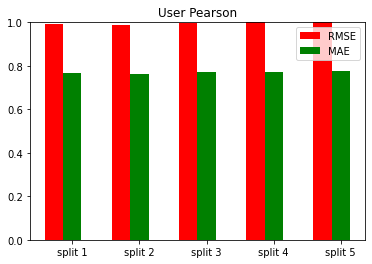

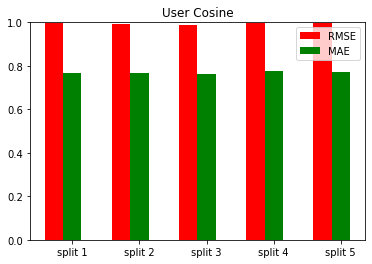

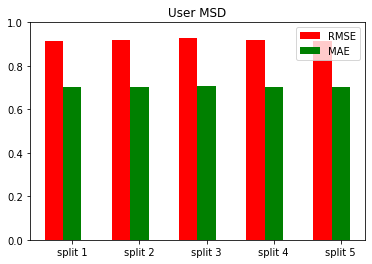

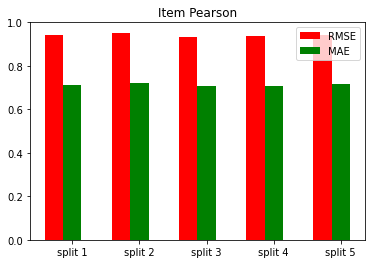

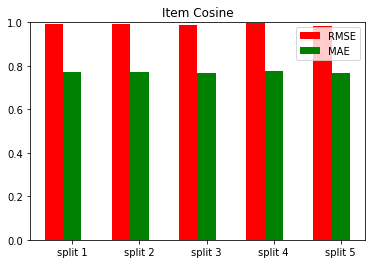

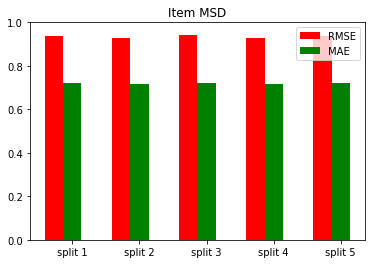

In [106]:
plotData(np.array(userPearson['test_rmse']),np.array(userPearson['test_mae']),"User Pearson")
plotData(np.array(userCosine['test_rmse']),np.array(userCosine['test_mae']),"User Cosine")
plotData(np.array(userMSD['test_rmse']),np.array(userMSD['test_mae']),"User MSD")
plotData(np.array(itemPearson['test_rmse']),np.array(itemPearson['test_mae']),"Item Pearson")
plotData(np.array(itemCosine['test_rmse']),np.array(itemCosine['test_mae']),"Item Cosine")
plotData(np.array(itemMSD['test_rmse']),np.array(itemMSD['test_mae']),"Item MSD")

In [80]:
from surprise.model_selection import train_test_split
from surprise import accuracy
def maxAccuracy(decision,sqrted=100):
  error_rate = np.zeros((2,sqrted))
  for i in range(1,sqrted):
    knn = KNNBasic(k=i,sim_options={'name': 'MSD', 'user_based': decision},verbose='true')
    trainset, testset = train_test_split(data, test_size=.25)
    knn.fit(trainset)
    predictions = knn.test(testset)  
    error_rate[0][i] = accuracy.rmse(predictions)
    error_rate[1][i] = accuracy.mae(predictions)
  return error_rate
def printResults(error_rate,sqrted=100):
  ax = plt.figure(figsize=(10,6))
  rects1 = plt.plot(range(1,sqrted),error_rate[0,1:],color='blue', linestyle='dashed', 
          marker='o',markerfacecolor='red', markersize=10)
  rects2 = plt.plot(range(1,sqrted),error_rate[1,1:],color='purple', linestyle='dashed', 
          marker='o',markerfacecolor='orange', markersize=10)
  plt.title('Error Rate vs. K Value')  
  plt.xlabel('K')
  plt.ylabel('Error Rate')
  ax.legend( (rects1[0], rects2[0]), ('RMSE','MAE') )
  min1 = error_rate[0,1:].argmin()
  min2 = error_rate[1,1:].argmin()
  print("Minimum Accuracy RMSE:",min1,"at K =",error_rate[0,min1])
  print("Minimum Accuracy MAE:",min2,"at K =",error_rate[1,min2])


In [81]:
#split this because it takes 20 mins to run this algorithm
error1 = maxAccuracy(0)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3106
MAE:  0.9716
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.1389
MAE:  0.8687
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0830
MAE:  0.8328
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0419
MAE:  0.8028
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0169
MAE:  0.7851
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0079
MAE:  0.7773
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0006
MAE:  0.7740
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9828
MAE:  0.7605
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9751
MAE:  0.7546
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9712
MAE:  0.7532
Computing 

In [82]:
error2 = maxAccuracy(1)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2173
MAE:  0.9045
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0831
MAE:  0.8262
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0295
MAE:  0.7885
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0098
MAE:  0.7722
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9843
MAE:  0.7493
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9844
MAE:  0.7521
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9791
MAE:  0.7477
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9744
MAE:  0.7470
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9589
MAE:  0.7365
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9760
MAE:  0.7471
Computing 

(2, 100)
Minimum Accuracy RMSE: 61 at K = 0.9301282959942602
Minimum Accuracy MAE: 61 at K = 0.7166601991027315
Minimum Accuracy RMSE: 18 at K = 0.9696702435956598
Minimum Accuracy MAE: 18 at K = 0.7409946703320391


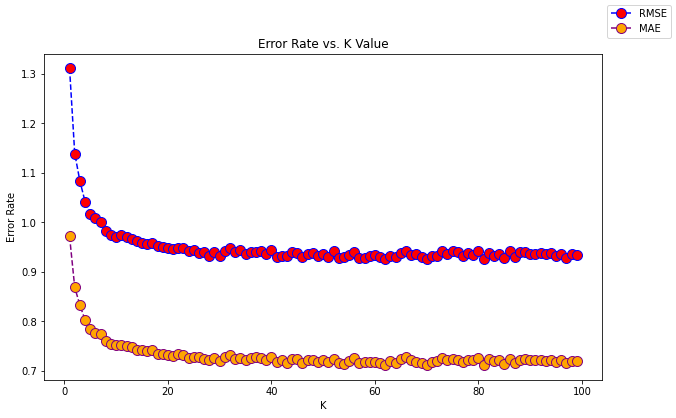

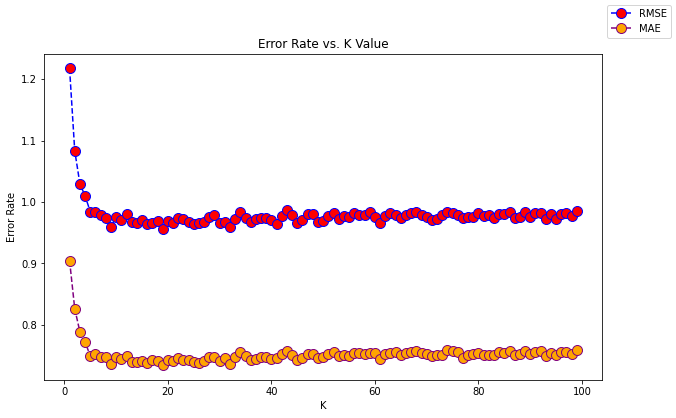

In [83]:
printResults(error1)
printResults(error2)